## Goal:
### Training a model for detection of car in a 2D image
<br>

## Data:
### 144 images of different cars with the corresponding mask
<br>

## Description:
### To solve this problem a modern CNN called Unet* is implemented in Keras with tensorflow backend. Training and validation is performed on 80% of data and the rest is used for test. Binary cross-entropy was used as a loss function and final test accuracy is reported as dice similarity.
_*Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." In International Conference on Medical image computing and computer-assisted intervention, pp. 234-241. Springer, Cham, 2015._
<br>

## Result:
### After training the model for 100 epoch with mini-batch size of 5 images, the accuracy of test set was 0.95. Dice similarity was equal to *****.
### Training phase took 6 minuetes on a single NVIDIA GeForce GTX 1050 GPU machine.

## Part 1: Data Preparation

In [2]:
# import libraries
import os
import cv2
import time
import h5py
import math
import queue
import pickle
import random
import threading
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy
from keras.models import Model, load_model
from sklearn.utils import shuffle
from keras.regularizers import l2
from scipy import misc, ndimage
from keras.optimizers import *
from keras import backend as K
from keras.layers import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

This code is based on tensorflow-gpu. f you do not have any GPU, replace tensorflow-gpu with tensorflow to train the network on CPU. Note that much higher training time is expected with CPU as compared to GPU.

In [4]:
# get name of available GPU devices
tf.test.gpu_device_name()

'/device:GPU:0'

NOTE: Here we first create a CSV file to save path/name of images. You can directly load image from the folder without any need for creating and loading from a CSV file. However, its recommended to have a cvs to make it easier to change the data set or load part of the data

In [7]:
# create csv file for the images and masks
if not os.path.exists('image.csv'):
    base_dir = os.path.join(os.getcwd(),'data')

    # generate csv file for images
    image_folder = base_dir + '\\images\\'
    images_in_folder = sorted(os.listdir(image_folder))

    # constructing data frame and saving csv file
    df = pd.DataFrame()
    df['images'] = [image_folder + str(x) for x in images_in_folder]
    df.to_csv('image.csv', header=None)

    # generate csv file for masks
    mask_folder = base_dir + '\\masks\\'
    masks_in_folder = sorted(os.listdir(mask_folder))

    # constructing data frame and saving csv file
    df = pd.DataFrame()
    df['masks'] = [mask_folder + str(x) for x in masks_in_folder]
    df.to_csv('mask.csv', header=None)

In [8]:
# import list of image and mask paths from the csv file
import csv
def get_path_csv(folder, csv_file):
    with open(os.path.join(folder, csv_file), 'r') as f:
        reader = csv.reader(f)
        meta_data = list(reader)
        path_list = [item[1] for item in meta_data]
    return path_list
try:
    csvFile.close()
except:
    print("Could not close CSV file")
    
folder = os.getcwd()
img_path = get_path_csv(folder, 'image.csv')
mask_path = get_path_csv(folder, 'mask.csv')

Could not close CSV file


Load images and adjust their hight (im_height) & width (im_width).Higher resolution provides better result but slows the training.<br>
__Original resolution is 1918x1280. For this project, a resolution of 64x64 provides good result.__<br>
- Images are normalized to have intensity values between 0 and 1
- If working with graysclae images, the dimensions need to be expanded (i.e. shape=(x,y,1))

In [10]:
# load images and adjust the resolution 
im_height = 64
im_width = 64

imgs = []
for i in img_path:
    img_array = cv2.imread(i, 1)/255
    new_array = cv2.resize(img_array, (im_height, im_width))
    #new_array = np.expand_dims(new_array, axis=-1)
    imgs.append(new_array)
    
masks = []
for i in mask_path:
    mask_array = cv2.imread(i, 1)/255
    new_mask = cv2.resize(mask_array, (im_height, im_width))
    #new_mask = np.expand_dims(new_mask, axis=-1)
    masks.append(new_mask)
    
    
# convert to numpy array
imgs_np = np.array(imgs, dtype=np.float32)
masks_np = np.array(masks, dtype=np.float32)

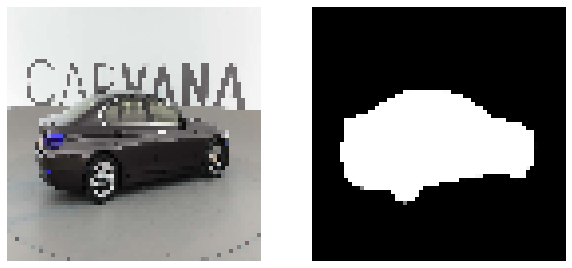

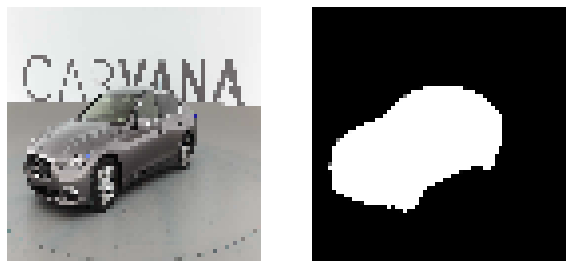

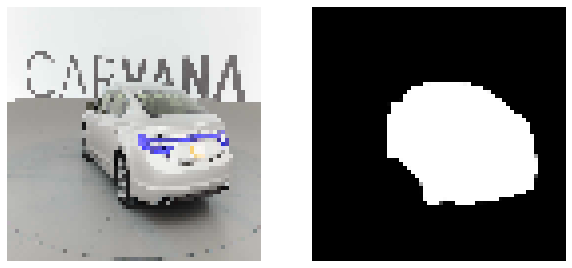

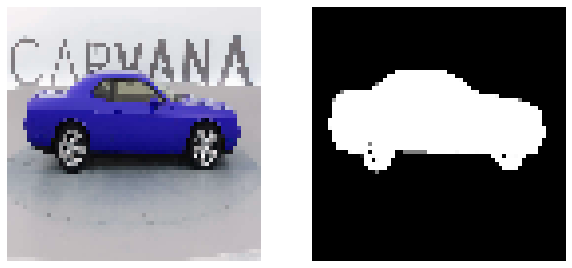

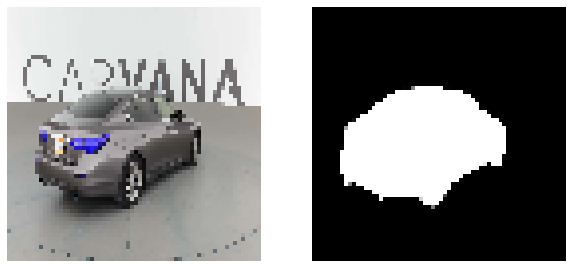

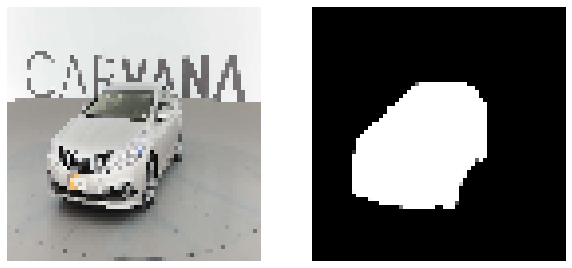

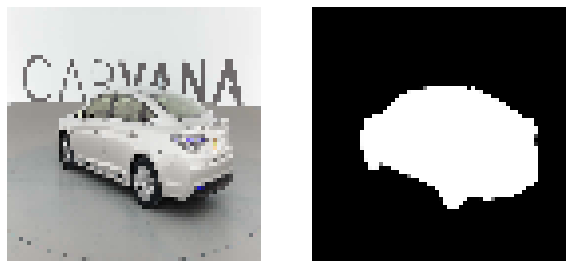

In [13]:
# visualize 7 randomly selected images and masks for sanity check
rand_idx = random.choices(range(0,len(imgs)), k=7)

for i in rand_idx:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imgs[i])
    ax[0].axis('off')
    ax[1].imshow(masks[i])
    ax[1].axis('off')

## Part 2: Model Implementation

Define 2D colvolutional layers with optional batch normalization to avoid overfitting. Then, Unet encoder-decoder structure is implemented in accoradance to the original paper. Also, type of optimizer, loss function and accuracy measure are determined. Finally, a callback function is defined to save model weights and allow early stopping in case loss does not change significantly after 10 iterations

In [17]:
# define 2D convolutional layer with relu activation function
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [18]:
# define 2D Unet network
def get_unet(input_img, n_filters=2, dropout=0.5, batchnorm=True):
    
    # contracting path (encoder)
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path (decoder)
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
# select input size and model parameters. We used keras built-in binary crossentropy loss
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=2, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 2)    56          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 2)    8           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [20]:
# define call back to save model and perform early stopping if loss does not imporove after 10 training epoch
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)]

## Part 3: Model Training

Split data into train/test, train model and visualize learning curve

In [21]:
# split dataset for test and train (80% for train/validation and 20% for test)
X_train, X_valid, y_train, y_valid = train_test_split(imgs_np, masks_np, test_size=0.2, random_state=1)

In [22]:
# train the model, select batch size and number of epoches
results = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=2, callbacks=None,
                    validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 115 samples, validate on 29 samples
Epoch 1/100
 - 6s - loss: 0.6581 - acc: 0.7486 - val_loss: 0.5641 - val_acc: 0.7541
Epoch 2/100
 - 1s - loss: 0.5950 - acc: 0.7566 - val_loss: 0.5599 - val_acc: 0.7611
Epoch 3/100
 - 1s - loss: 0.5577 - acc: 0.7589 - val_loss: 0.5519 - val_acc: 0.7718
Epoch 4/100
 - 1s - loss: 0.5194 - acc: 0.7684 - val_loss: 0.4884 - val_acc: 0.7737
Epoch 5/100
 - 1s - loss: 0.4866 - acc: 0.7696 - val_loss: 0.4253 - val_acc: 0.7737
Epoch 6/100
 - 1s - loss: 0.4605 - acc: 0.7696 - val_loss: 0.4071 - val_acc: 0.7737
Epoch 7/100
 - 1s - loss: 0.4394 - acc: 0.7696 - val_loss: 0.4043 - val_acc: 0.7737
Epoch 8/100
 - 1s - loss: 0.4216 - acc: 0.7696 - val_loss: 0.3960 - val_acc: 0.7737
Epoch 9/100
 - 1s - loss: 0.4055 - acc: 0.7696 - val_loss: 0.3987 - val_acc: 0.7737
Epoch 10/100
 - 1s - loss: 0.3909 - acc: 0.7696 - val_loss: 0.4004 - val_acc: 0.7737
Epoch 11/100
 - 1s - loss: 0.3778 - acc: 0.7696 - val_loss: 0.3938

Epoch 94/100
 - 1s - loss: 0.0911 - acc: 0.9772 - val_loss: 0.0954 - val_acc: 0.9746
Epoch 95/100
 - 1s - loss: 0.0898 - acc: 0.9774 - val_loss: 0.0984 - val_acc: 0.9736
Epoch 96/100
 - 1s - loss: 0.0890 - acc: 0.9775 - val_loss: 0.0926 - val_acc: 0.9749
Epoch 97/100
 - 1s - loss: 0.0878 - acc: 0.9776 - val_loss: 0.0936 - val_acc: 0.9745
Epoch 98/100
 - 1s - loss: 0.0869 - acc: 0.9776 - val_loss: 0.0921 - val_acc: 0.9751
Epoch 99/100
 - 1s - loss: 0.0865 - acc: 0.9773 - val_loss: 0.0910 - val_acc: 0.9749
Epoch 100/100
 - 1s - loss: 0.0856 - acc: 0.9777 - val_loss: 0.0899 - val_acc: 0.9751


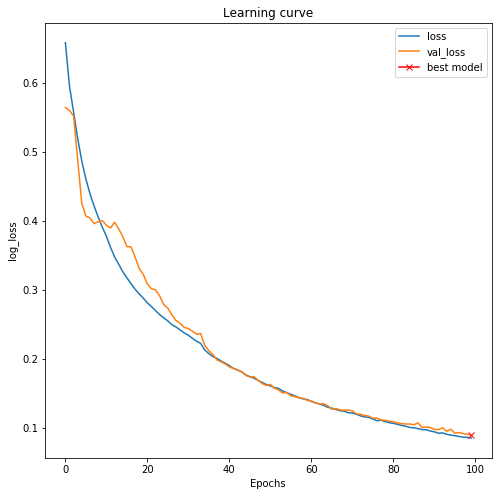

In [23]:
# plot training and validation loss, then highlight best model
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Part 4: Result

Make prediction based on trained model and quantify the result in terms of cross-entropy loss and accuracy measures. Also, visualize random predictions for sanity check.

In [34]:
# make prediction based on the trained network
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

29/29 [==============================] - 0s 344us/step


In [32]:
# model evaluation based on cross-entropy loss and accuracy
loss, acc =  model.evaluate(X_valid, y_valid, batch_size=30, verbose=1)
display('Evaluation loss is equal to: {0:.2f}'.format(loss))
display('Evaluation accuracy is equal to: {0:.2f}'.format(acc))

29/29 [==============================] - 0s 415us/step


'Evaluation loss is equal to: 0.09'

'Evaluation accuracy is equal to: 0.98'

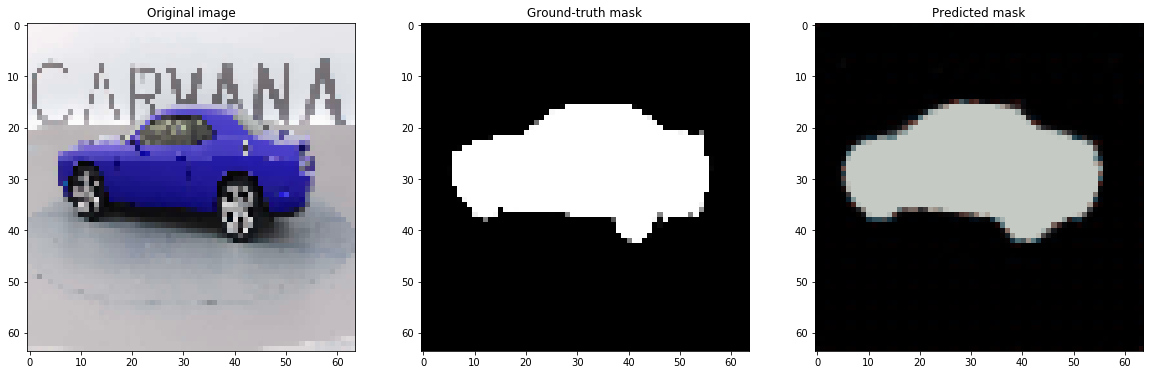

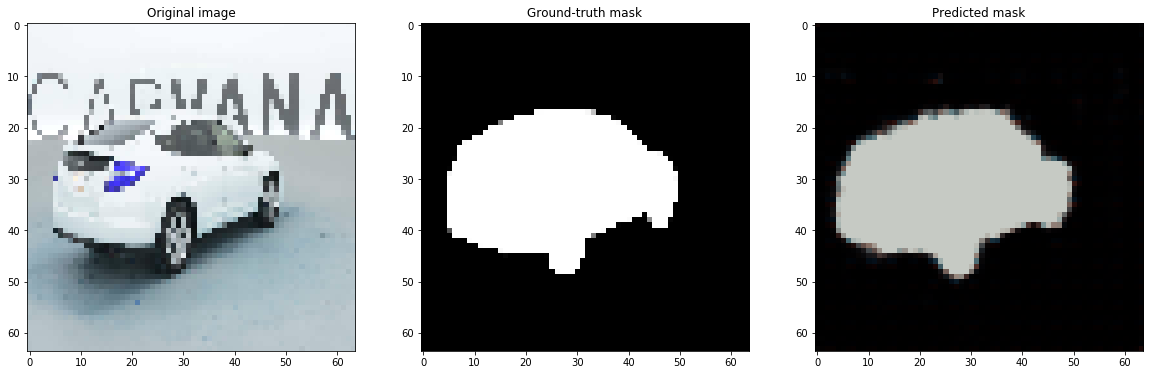

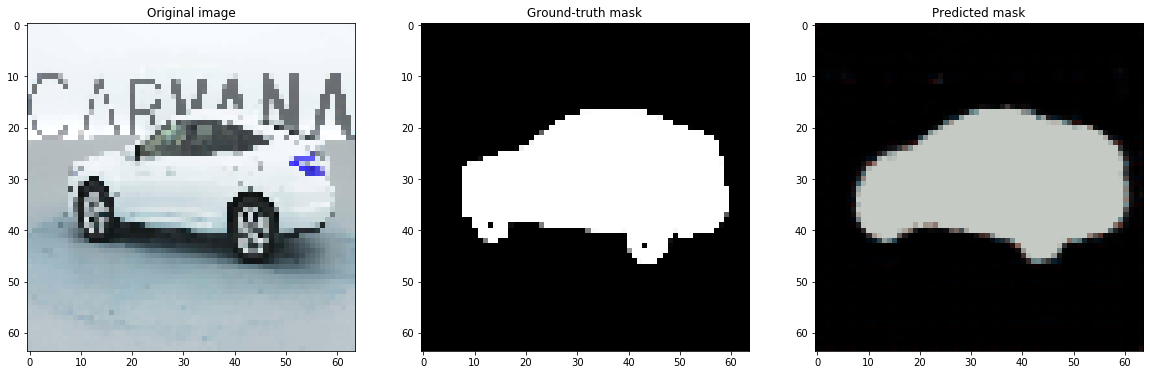

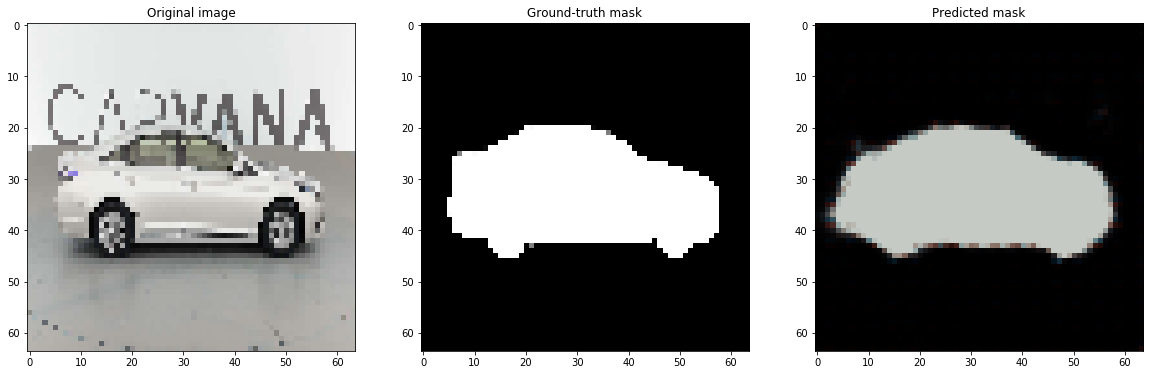

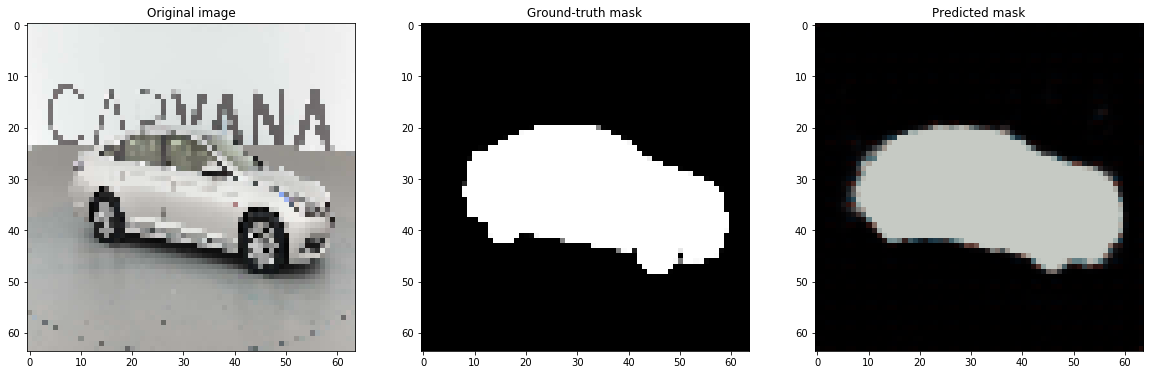

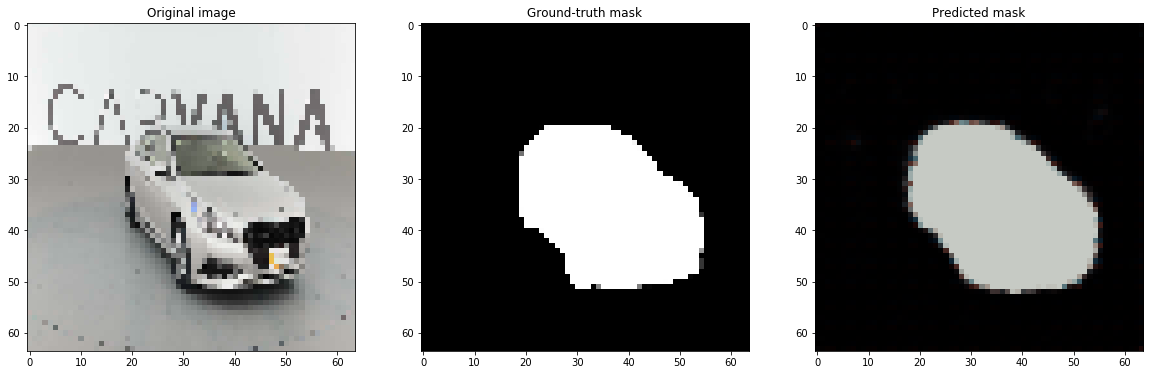

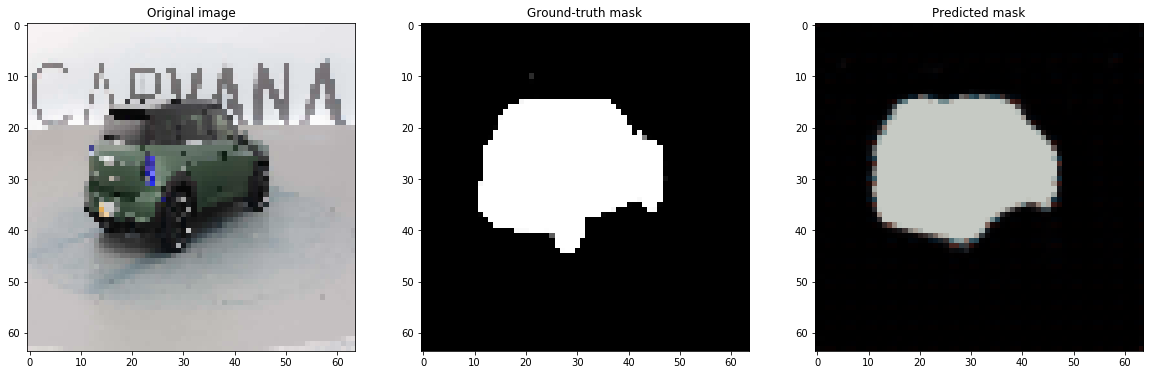

In [70]:
# visualize examples from validation dataset for sanity check
rand_idx = random.choices(range(0,len(X_valid)), k=7)

for idx in rand_idx:
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X_valid[idx].squeeze(), cmap='gray')
    ax[0].title.set_text('Original image')
    ax[1].imshow(y_valid[idx].squeeze(), cmap='gray')
    ax[1].title.set_text('Ground-truth mask')
    ax[2].imshow(preds_val[idx].squeeze(), cmap='gray')
    ax[2].title.set_text('Predicted mask')

Define a function for calculating dice similarity. Dice is important as it qualtifies overlap of the result with ground-truth mask.

In [35]:
# function for calculating dice similarity between pair of images.
import numpy as np

def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
          Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [78]:
# convert validation RGB images to binary - necessary for Dice similarity calculation
y_valid_bw = []
for i in range(0, len(y_valid)):
    gray_image = cv2.cvtColor(y_valid[i].squeeze(), cv2.COLOR_BGR2GRAY)
    (thresh, bw_img) = cv2.threshold(gray_image, 0.1, 255, cv2.THRESH_BINARY)
    y_valid_bw.append(bw_img)

preds_val_bw = []
for i in range(0, len(preds_val)):
    gray_image = cv2.cvtColor(preds_val[i].squeeze(), cv2.COLOR_BGR2GRAY)
    (thresh, bw_img) = cv2.threshold(gray_image, 0.1, 255, cv2.THRESH_BINARY)
    preds_val_bw.append(bw_img)

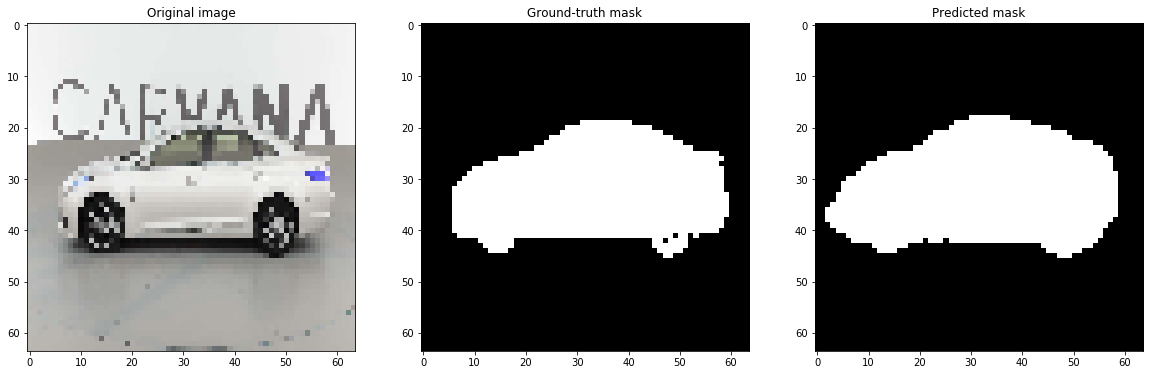

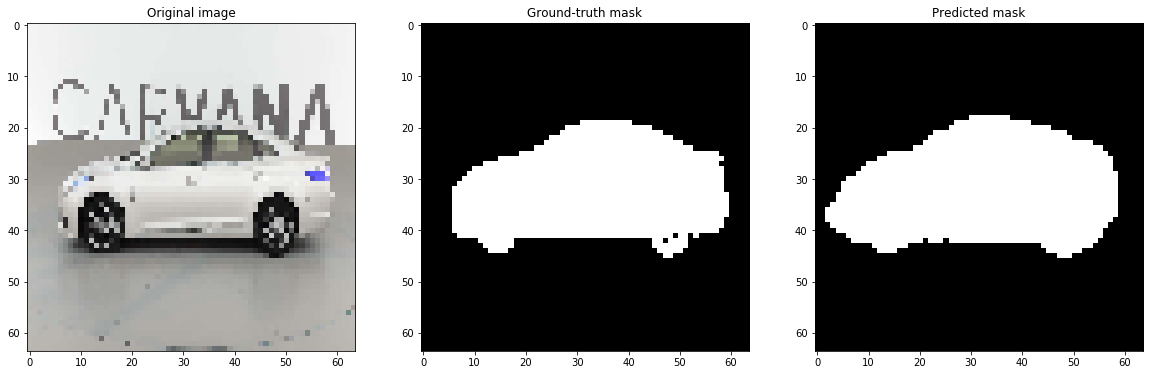

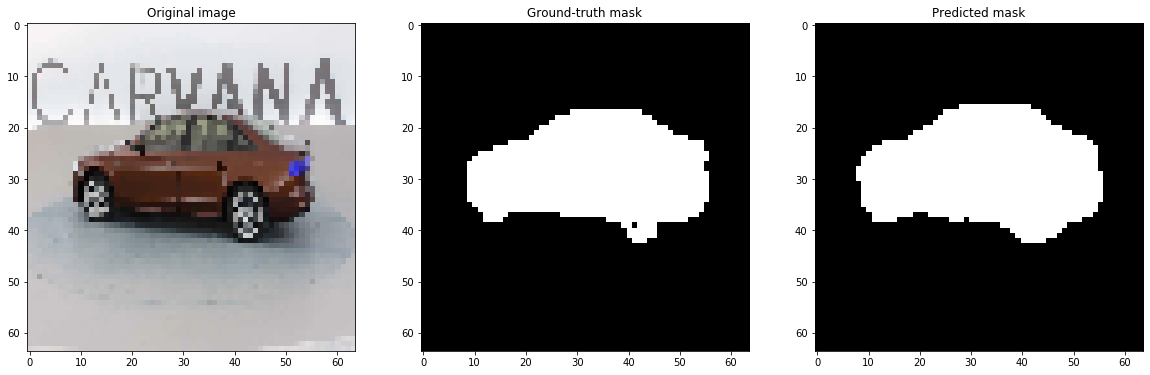

In [88]:
# visualize 3 ransom images for sanity check. Make sure images are binary and car area is visible
rand_idx = random.choices(range(0,len(X_valid)), k=3)

for idx in rand_idx:
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X_valid[idx], cmap='gray')
    ax[0].title.set_text('Original image')
    ax[1].imshow(y_valid_bw[idx].squeeze(), cmap='gray')
    ax[1].title.set_text('Ground-truth mask')
    ax[2].imshow(preds_val_bw[idx], cmap='gray')
    ax[2].title.set_text('Predicted mask')

In [82]:
# dice similarity for the entire validation set

# dice_arr = np.empty((len(preds_val_t)), float)
dic_arr = []
for idx in range(0,len(y_valid_bw)):
    dice_val = dice(y_valid_bw[idx], preds_val_bw[idx])
    dic_arr.append(dice_val)
#     dice_arr = np.append(dice_arr, dice_val, axis=0)

In [87]:
# mean dice value for test set
mean_dice = np.mean(np.array(dic_arr))
print('Mean dice similarity for {} test images is equal to {}'.format(len(y_valid_bw),np.round(mean_dice,2)))

Mean dice similarity for 29 test images is equal to 0.94
